In [353]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier


from sklearn.model_selection import GridSearchCV, cross_validate


All questions in this section pertain to two of the datasets listed above in Exam Materials
(training_set_data.csv and unlabeled_data.csv), with the data_dictionary.txt file providing the
metadata needed to understand the contents and formats of each .csv. 

Please note that the data is still in its raw, original form and may require some cleaning and/or standardization.


Imagine we are being asked by one of our clients, ACME X, to predict if a given individual is
uninsured or not (health insurance). Using the data in training_set_data.csv, please train a model
to predict whether each person in the data set is uninsured or not. 


Furthermore, our main contact
at ACME X will need to explain the basics of the model to their smart, but non-technical
coworkers, so interpretability of how the model inputs relate to the predictions will be important.

In [354]:
train = pd.read_csv('training_set_data.csv')
pd.set_option('display.max_columns', 500)
train.head(3)

,person_id,age,citizen_status,nativity_status,weekly_hours_worked,total_income,self_employed_income,wage_income,interest_income,other_income,marital_status,school_status,sex,when_last_worked,worked_last_week,language,race_native_american,race_asian,race_black,race_native_hawaiian,race_pacific_islander,race_white,race_other,uninsured,household_id
0,1,45,citizen_birth,native_born,15,908.0,62.0,800.0,11.0,35.0,married,not_student,FEMALE,in_last_year,worked,English,0,0,0,0,0,1,0,0,1
1,2,47,citizen_birth,native_born,50,180499.0,49.0,160007.0,20424.0,19.0,married,not_student,MALE,in_last_year,worked,English,0,0,0,0,0,1,0,0,1
2,4,26,citizen_birth,native_born,0,7367.0,93.0,4.0,20.0,7250.0,never_married,not_student,male,over_five_years_ago,not_reported,English,0,0,1,0,0,0,0,0,2


## EDA

In [355]:
train.school_status.value_counts()

not_student       53862
public_school      3914
private_school     1821
Name: school_status, dtype: int64

In [356]:
train.sex = train.sex.replace({'FEMALE': 'F'})
train.sex = train.sex.replace({'female': 'F'})

train.sex = train.sex.replace({'MALE': 'M'})
train.sex = train.sex.replace({'male': 'M'})

train.sex.value_counts()

F    30834
M    28763
Name: sex, dtype: int64

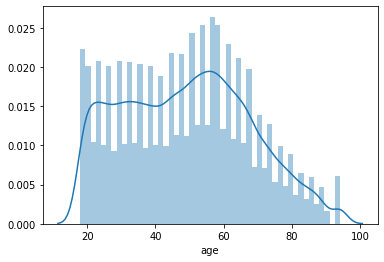

In [391]:
sns.distplot(train.age)

In [392]:
unlabeled = pd.read_csv('unlabeled_data.csv')
pd.set_option('display.max_columns', 500)
unlabeled.head()

,person_id,age,citizen_status,nativity_status,weekly_hours_worked,total_income,self_employed_income,wage_income,interest_income,other_income,marital_status,school_status,sex,when_last_worked,worked_last_week,language,race_native_american,race_asian,race_black,race_native_hawaiian,race_pacific_islander,race_white,race_other,household_id
0,12,28,citizen_birth,native_born,45,15254.0,15081.0,82.0,16.0,75.0,never_married,not_student,MALE,in_last_year,worked,English,0,0,0,0,0,1,0,6
1,13,40,citizen_birth,native_born,32,10291.0,45.0,9068.0,57.0,1121.0,divorced,not_student,MALE,in_last_year,worked,English,0,0,0,0,0,1,0,7
2,22,68,citizen_birth,native_born,0,13194.0,80.0,34.0,69.0,13011.0,married,not_student,MALE,over_five_years_ago,did_not_work,English,0,0,0,0,0,1,0,13
3,23,64,citizen_birth,native_born,40,30194.0,33.0,30094.0,37.0,30.0,married,not_student,F,in_last_year,worked,English,0,0,0,0,0,1,0,13
4,25,29,citizen_birth,native_born,40,52174.0,12.0,52101.0,52.0,9.0,never_married,not_student,MALE,in_last_year,worked,English,0,0,0,0,0,1,0,15


In [393]:
train.head()

,person_id,age,citizen_status,nativity_status,weekly_hours_worked,total_income,self_employed_income,wage_income,interest_income,other_income,marital_status,school_status,sex,when_last_worked,worked_last_week,language,race_native_american,race_asian,race_black,race_native_hawaiian,race_pacific_islander,race_white,race_other,uninsured,household_id
0,1,45,citizen_birth,native_born,15,908.0,62.0,800.0,11.0,35.0,married,not_student,F,in_last_year,worked,English,0,0,0,0,0,1,0,0,1
1,2,47,citizen_birth,native_born,50,180499.0,49.0,160007.0,20424.0,19.0,married,not_student,M,in_last_year,worked,English,0,0,0,0,0,1,0,0,1
2,4,26,citizen_birth,native_born,0,7367.0,93.0,4.0,20.0,7250.0,never_married,not_student,M,over_five_years_ago,not_reported,English,0,0,1,0,0,0,0,0,2
3,5,42,citizen_naturalized,foreign_born,0,22970.0,51.0,46.0,283.0,22590.0,never_married,public_school,M,in_last_five_years,did_not_work,Korean,0,1,0,0,0,0,0,0,3
4,6,79,citizen_naturalized,foreign_born,0,7941.0,23.0,94.0,73.0,7751.0,married,not_student,M,over_five_years_ago,did_not_work,Korean,0,1,0,0,0,0,0,0,3


In [394]:
#Target and independent variables

X = train.drop(['person_id', 'uninsured', 'language', 'household_id'], axis=1)
y= train['uninsured']


## One hot encoder

In [395]:
cont = X.select_dtypes(exclude='object')

cat = X.select_dtypes(include='object')

###  Scaling cont  variables 

In [396]:
for col in cont.columns:
    cont[col]= (cont[col]-min(cont[col]))/(max(cont[col]-min(cont[col])))

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [397]:
cont = cont.round(2)
cont.head()

,age,weekly_hours_worked,total_income,self_employed_income,wage_income,interest_income,other_income,race_native_american,race_asian,race_black,race_native_hawaiian,race_pacific_islander,race_white,race_other
0,0.36,0.15,0.00,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.38,0.51,0.17,0.0,0.32,0.08,0.00,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.11,0.00,0.01,0.0,0.00,0.00,0.03,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.32,0.00,0.02,0.0,0.00,0.00,0.09,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.80,0.00,0.01,0.0,0.00,0.00,0.03,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [398]:
ehe = OneHotEncoder(drop='first')


In [399]:
tran = ehe.fit_transform(cat).toarray()

In [400]:
tran_df= pd.DataFrame(tran, columns=ehe.get_feature_names(cat.columns))

In [401]:
tran_df.head(2)

,citizen_status_citizen_naturalized,citizen_status_noncitizen,nativity_status_native_born,marital_status_married,marital_status_never_married,marital_status_separated,marital_status_widowed,school_status_private_school,school_status_public_school,sex_M,when_last_worked_in_last_year,when_last_worked_over_five_years_ago,worked_last_week_not_reported,worked_last_week_worked
0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0


In [402]:
tran_df.reset_index(inplace=True, drop=True)


In [403]:
cont.reset_index(inplace=True, drop=True)

In [404]:
X = tran_df.join(cont)

In [405]:
X.head(2)

,citizen_status_citizen_naturalized,citizen_status_noncitizen,nativity_status_native_born,marital_status_married,marital_status_never_married,marital_status_separated,marital_status_widowed,school_status_private_school,school_status_public_school,sex_M,when_last_worked_in_last_year,when_last_worked_over_five_years_ago,worked_last_week_not_reported,worked_last_week_worked,age,weekly_hours_worked,total_income,self_employed_income,wage_income,interest_income,other_income,race_native_american,race_asian,race_black,race_native_hawaiian,race_pacific_islander,race_white,race_other
0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.36,0.15,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.38,0.51,0.17,0.0,0.32,0.08,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## Train test split

In [406]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=28)

### Logistic Regression

In [407]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(fit_intercept=False, C=1e12, solver='liblinear')

model = logreg.fit(X_train, y_train)

In [408]:
model.score(X_test, y_test)

0.9244295302013423

In [409]:
y_pred = logreg.predict(X_test)

In [410]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_pred)

array([[13677,    79],
       [ 1047,    97]])

 True positive  = 13677
 
 
 False positive = 79


False Negativ = 1047


True Negative 97

In [411]:
coef = model.coef_.reshape(-1)

In [412]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
log_confusion = confusion_matrix(y_test, y_pred, normalize='true')
class_report = classification_report(y_test, y_pred)

print(log_confusion)
print(class_report)

[[0.99425705 0.00574295]
 [0.91520979 0.08479021]]
              precision    recall  f1-score   support

           0       0.93      0.99      0.96     13756
           1       0.55      0.08      0.15      1144

    accuracy                           0.92     14900
   macro avg       0.74      0.54      0.55     14900
weighted avg       0.90      0.92      0.90     14900



In [413]:
df_coef = pd.DataFrame(X_train.columns)

df_coef['features'] = coef

df_coef.columns = ['coef', 'features']

#df['features'] = df_coef.features.sort_values(ascending=False)

df_coef.head()

,coef,features
0,citizen_status_citizen_naturalized,-1.643292
1,citizen_status_noncitizen,-0.043848
2,nativity_status_native_born,-2.085961
3,marital_status_married,-0.602243
4,marital_status_never_married,-0.052868


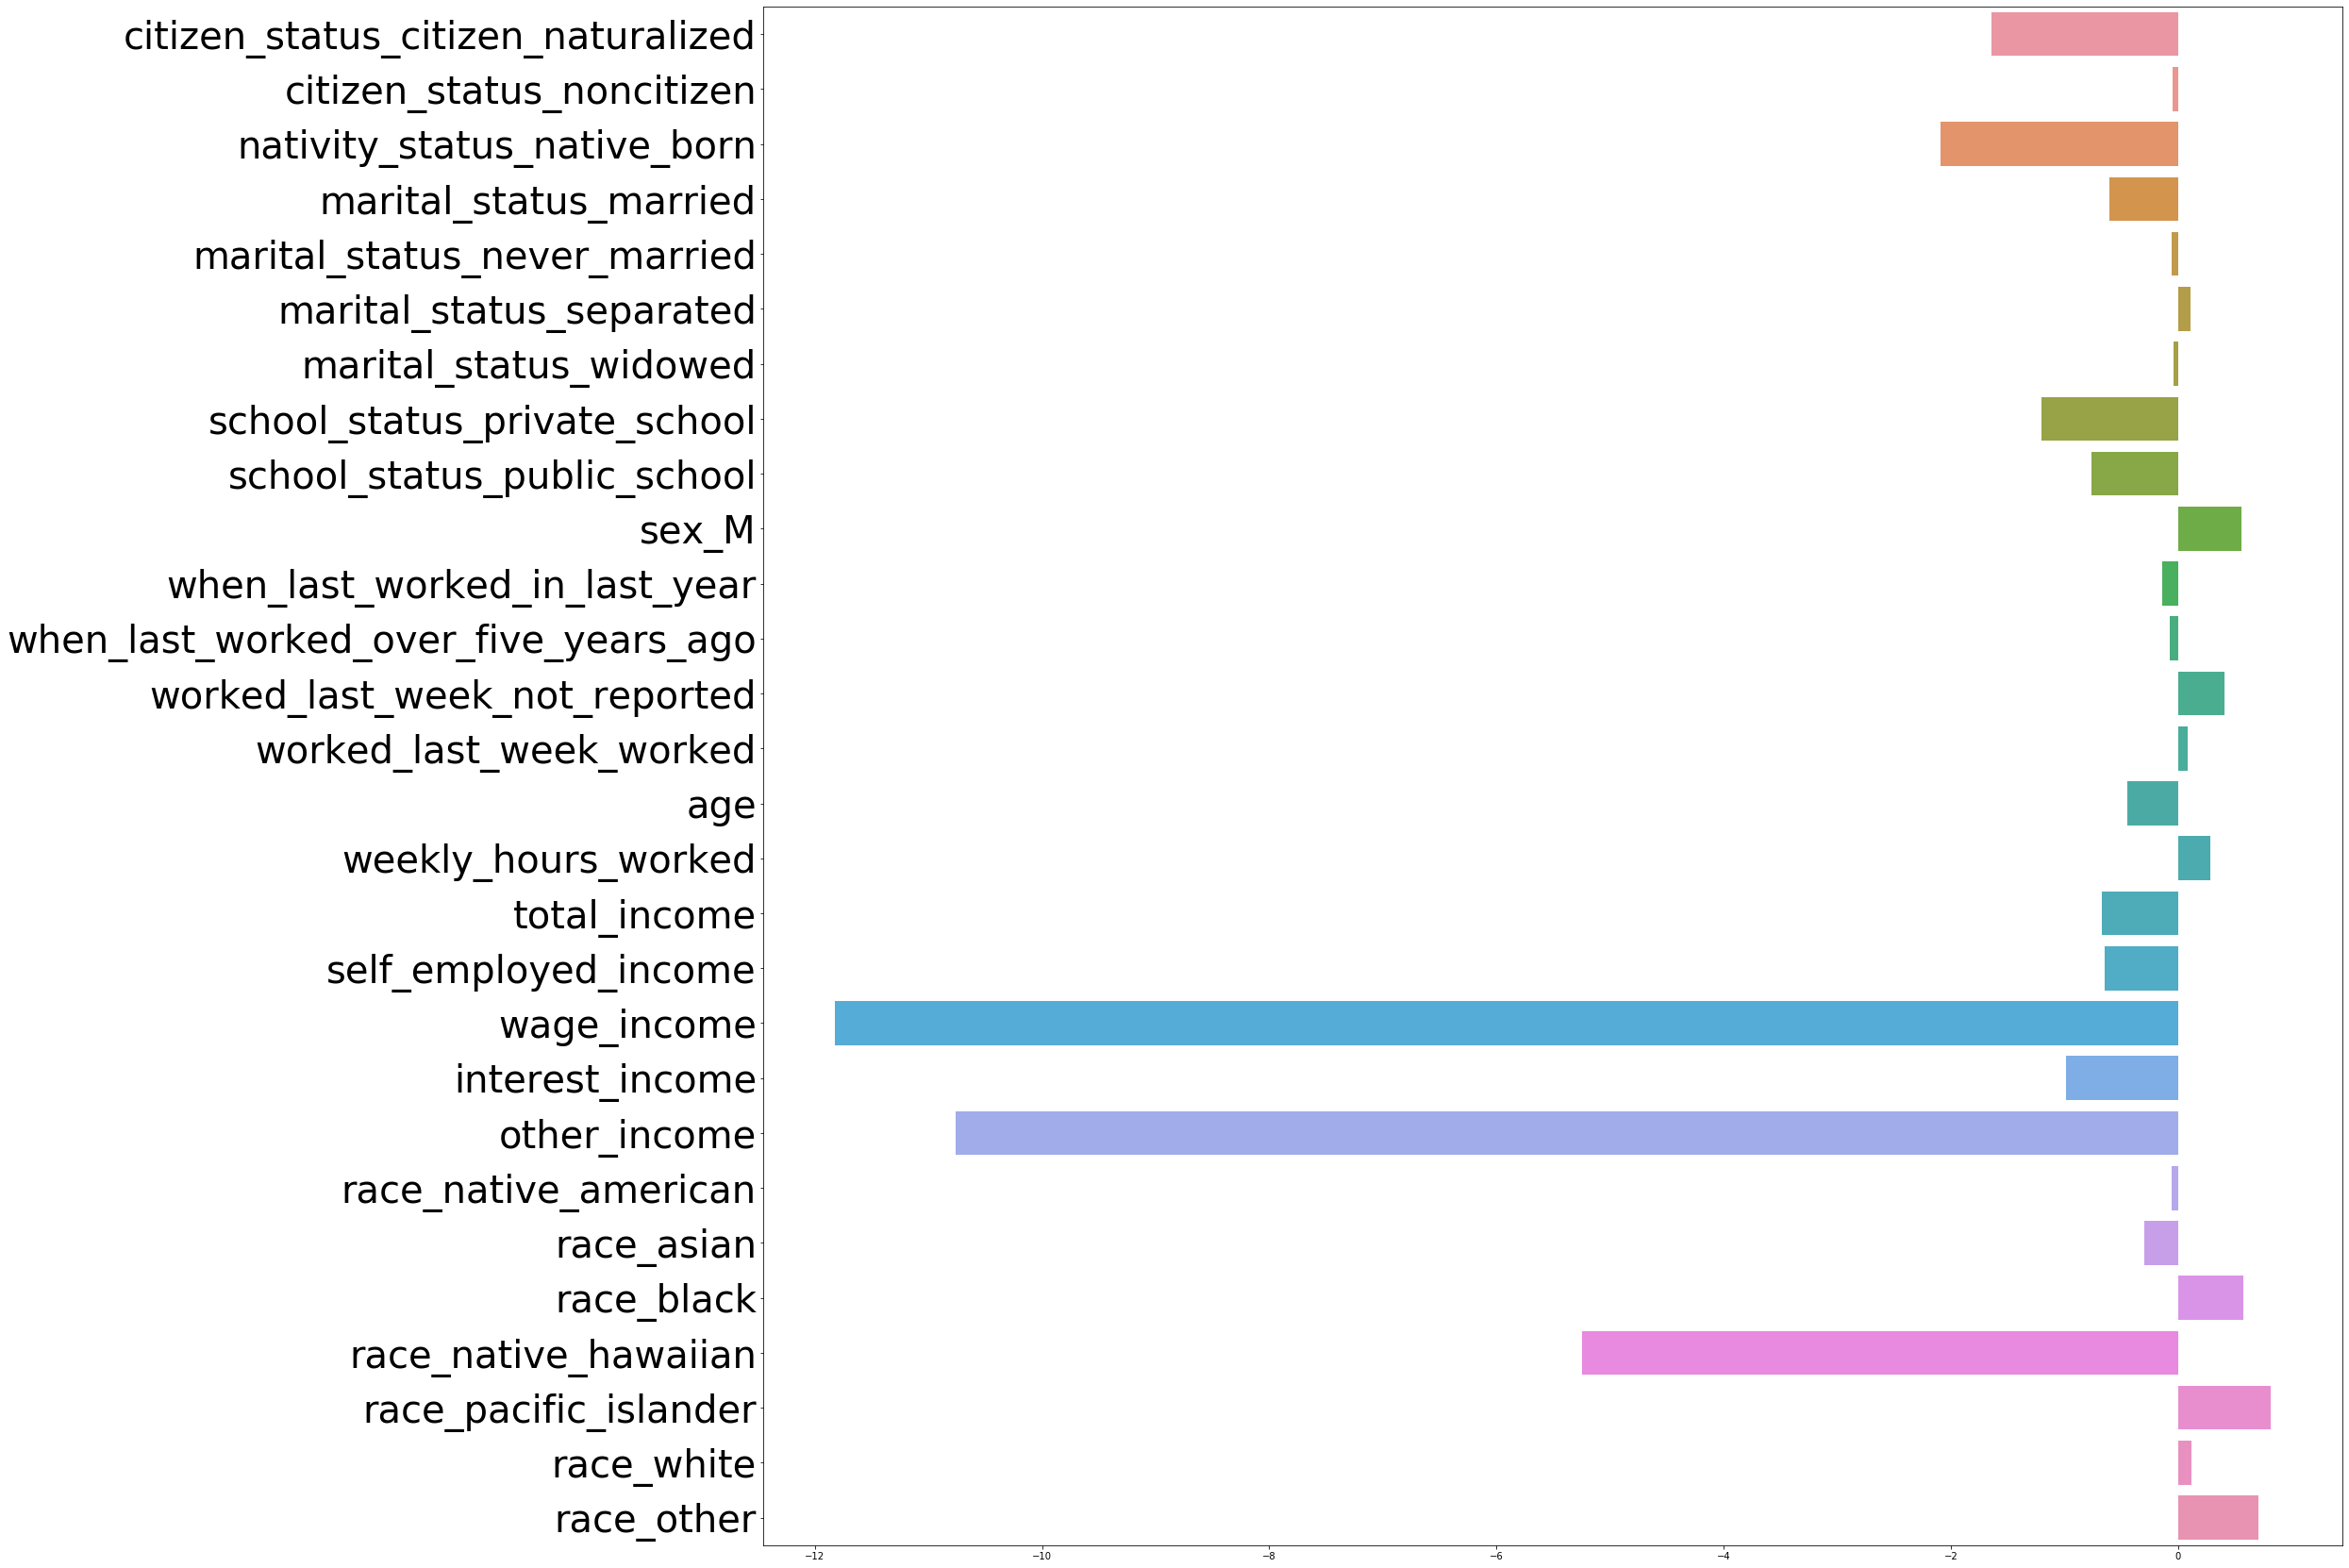

In [414]:
plt.figure(figsize=(30,30))
sns.barplot(x=coef, y=X_train.columns)
plt.yticks(fontsize=40)
plt.show()

0: Has health insurance.


1: Does not have health insurance.

A negative coefficient suggests that as the independent variable increases, the dependent variable tends to decrease

In [416]:
unlabeled.head(2)

,person_id,age,citizen_status,nativity_status,weekly_hours_worked,total_income,self_employed_income,wage_income,interest_income,other_income,marital_status,school_status,sex,when_last_worked,worked_last_week,language,race_native_american,race_asian,race_black,race_native_hawaiian,race_pacific_islander,race_white,race_other,household_id
0,12,28,citizen_birth,native_born,45,15254.0,15081.0,82.0,16.0,75.0,never_married,not_student,MALE,in_last_year,worked,English,0,0,0,0,0,1,0,6
1,13,40,citizen_birth,native_born,32,10291.0,45.0,9068.0,57.0,1121.0,divorced,not_student,MALE,in_last_year,worked,English,0,0,0,0,0,1,0,7


In [417]:
unlabeled.sex = unlabeled.sex.replace({'FEMALE': 'F'})
unlabeled.sex = unlabeled.sex.replace({'female': 'F'})

unlabeled.sex = unlabeled.sex.replace({'MALE': 'M'})
unlabeled.sex = unlabeled.sex.replace({'male': 'M'})

unlabeled.head()

,person_id,age,citizen_status,nativity_status,weekly_hours_worked,total_income,self_employed_income,wage_income,interest_income,other_income,marital_status,school_status,sex,when_last_worked,worked_last_week,language,race_native_american,race_asian,race_black,race_native_hawaiian,race_pacific_islander,race_white,race_other,household_id
0,12,28,citizen_birth,native_born,45,15254.0,15081.0,82.0,16.0,75.0,never_married,not_student,M,in_last_year,worked,English,0,0,0,0,0,1,0,6
1,13,40,citizen_birth,native_born,32,10291.0,45.0,9068.0,57.0,1121.0,divorced,not_student,M,in_last_year,worked,English,0,0,0,0,0,1,0,7
2,22,68,citizen_birth,native_born,0,13194.0,80.0,34.0,69.0,13011.0,married,not_student,M,over_five_years_ago,did_not_work,English,0,0,0,0,0,1,0,13
3,23,64,citizen_birth,native_born,40,30194.0,33.0,30094.0,37.0,30.0,married,not_student,F,in_last_year,worked,English,0,0,0,0,0,1,0,13
4,25,29,citizen_birth,native_born,40,52174.0,12.0,52101.0,52.0,9.0,never_married,not_student,M,in_last_year,worked,English,0,0,0,0,0,1,0,15


In [426]:
unlabeled_new = unlabeled.drop(['person_id','language', 'household_id'], axis=1)

In [427]:
cont = unlabeled_new.select_dtypes(exclude='object')

cat = unlabeled_new.select_dtypes(include='object')

In [428]:
for col in cont.columns:
    cont[col]= (cont[col]-min(cont[col]))/(max(cont[col]-min(cont[col])))

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [429]:
ehe = OneHotEncoder(drop='first')
tran = ehe.fit_transform(cat).toarray()
tran_df= pd.DataFrame(tran, columns=ehe.get_feature_names(cat.columns))
tran_df.head(2)

,citizen_status_citizen_naturalized,citizen_status_noncitizen,nativity_status_native_born,marital_status_married,marital_status_never_married,marital_status_separated,marital_status_widowed,school_status_private_school,school_status_public_school,sex_M,when_last_worked_in_last_year,when_last_worked_over_five_years_ago,worked_last_week_not_reported,worked_last_week_worked
0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0


In [430]:
tran_df.reset_index(inplace=True, drop=True)


In [431]:
cont.reset_index(inplace=True, drop=True)

In [432]:
new = tran_df.join(cont)

In [433]:
new.head(2)

,citizen_status_citizen_naturalized,citizen_status_noncitizen,nativity_status_native_born,marital_status_married,marital_status_never_married,marital_status_separated,marital_status_widowed,school_status_private_school,school_status_public_school,sex_M,when_last_worked_in_last_year,when_last_worked_over_five_years_ago,worked_last_week_not_reported,worked_last_week_worked,age,weekly_hours_worked,total_income,self_employed_income,wage_income,interest_income,other_income,race_native_american,race_asian,race_black,race_native_hawaiian,race_pacific_islander,race_white,race_other
0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.131579,0.454545,0.014366,0.048633,0.000162,0.000065,0.000353,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.289474,0.323232,0.009685,0.000145,0.017953,0.000233,0.005276,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [439]:
predictions = logreg.predict_proba(new)

df = pd.DataFrame(predictions)

df['person_id'] = unlabeled.person_id


df

,0,1,person_id
0,0.815225,0.184775,12
1,0.854152,0.145848,13
2,0.954382,0.045618,22
3,0.970562,0.029438,23
4,0.937661,0.062339,25
...,...,...,...
20167,0.988874,0.011126,126592
20168,0.980831,0.019169,126623
20169,0.981688,0.018312,126624
20170,0.950523,0.049477,126640


The first column corresponds to the probability that the sample belongs to the first class and the second column corresponds to the probability that the sample belongs to the second class.

Please write your answers in this document, and include your code (including any exploratory or
data-munging code) as part3_code.txt. 


In addition, please apply your model to the observations in
unlabeled_data.csv to produce individual probability predictions of uninsurance. 

After that, place
the person_id column and the associated scores into a file called part3_scores.csv. The headers on
this csv should be “person_id” and “score” for person_id and predicted scores, respectively.